In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import librosa as lib
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pathlib
dataset_path = r'C:\Users\udayr\miniconda3\envs\tf\FinalProject'
data_dir = pathlib.Path(dataset_path)

In [3]:
import numpy as np
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'LICENSE') & (commands!='_background_noise_')& (commands != 'speech_commands_v0.01.tar') & (commands != 'speech_commands_v0.01.tar.gz') & (commands!='testing_list.txt') & (commands!='README.md') & (commands!='validation_list.txt')]
print('Commands:', commands)

Commands: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'untitled_project' 'up' 'wow'
 'yes' 'zero']


In [4]:
# Audio clips= 1s (<16kHz), hence audio_seq_length=16000
batchsize=64
trn_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=batchsize,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(trn_ds.class_names)
print("label names:", label_names)

Found 64721 files belonging to 31 classes.
Using 51777 files for training.
Using 12944 files for validation.
label names: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'untitled_project' 'up' 'wow'
 'yes' 'zero']


In [5]:
print(trn_ds.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

trn_ds = trn_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
# Splitting validation set into test and validation
tst_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for ex_audio, ex_labels in trn_ds.take(1):  
  print(ex_audio.shape)
  print(ex_labels.shape)

(64, 16000)
(64,)


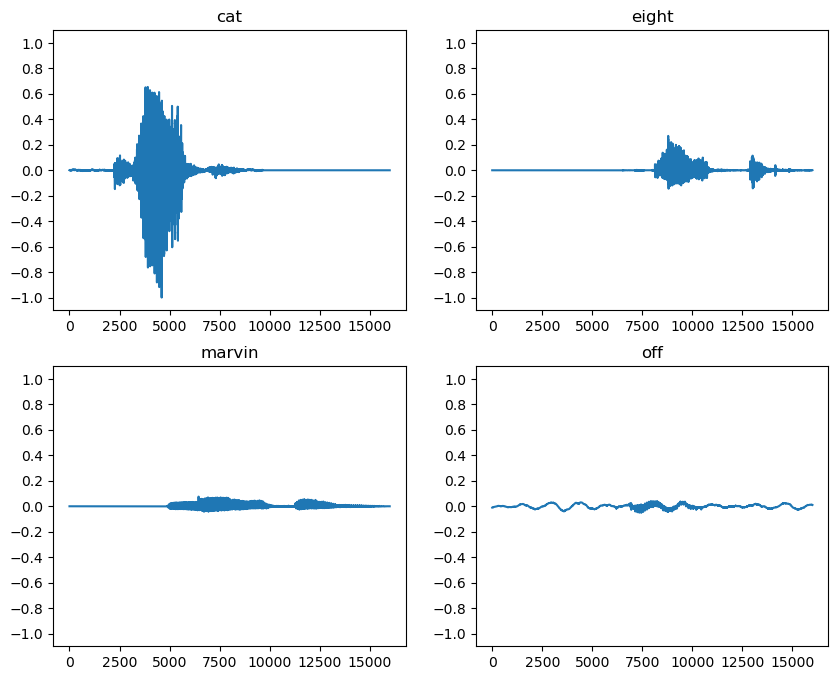

In [9]:
plt.figure(figsize=(10, 8))
rows = 2
cols = 2
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = ex_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[ex_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


In [10]:
# Now we convert these waves into spectograms by fourier transforms
def to_spectogram(waveform):
  # Using STFT
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  #To get just the magnitude
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [11]:
for i in range(3):
  label = label_names[ex_labels[i]]
  waveform = ex_audio[i]
  spectrogram = to_spectogram(waveform)
  # print(spectrogram.shape)
  # print(np.size(spectrogram))

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))
  

Label: cat
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: eight
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: marvin
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [12]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

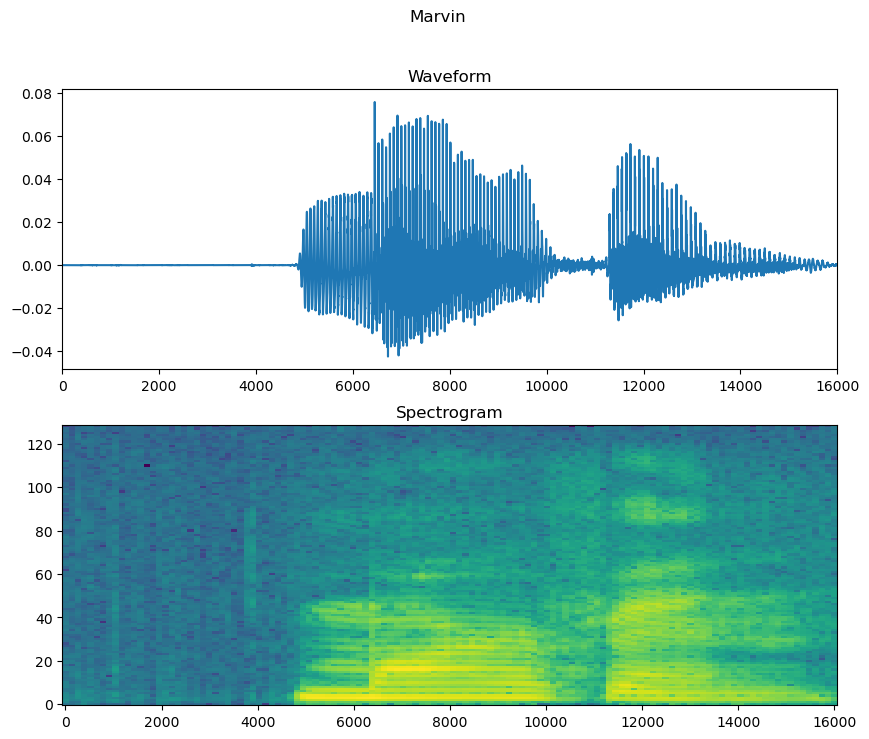

In [13]:
fig, axes = plt.subplots(2,figsize=(10,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy()) # Plotting waveform w.r.t time
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [14]:
def spectogram_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (to_spectogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
trn_spectrogram_ds = spectogram_ds(trn_ds)
val_spectrogram_ds = spectogram_ds(val_ds)
tst_spectrogram_ds = spectogram_ds(tst_ds)

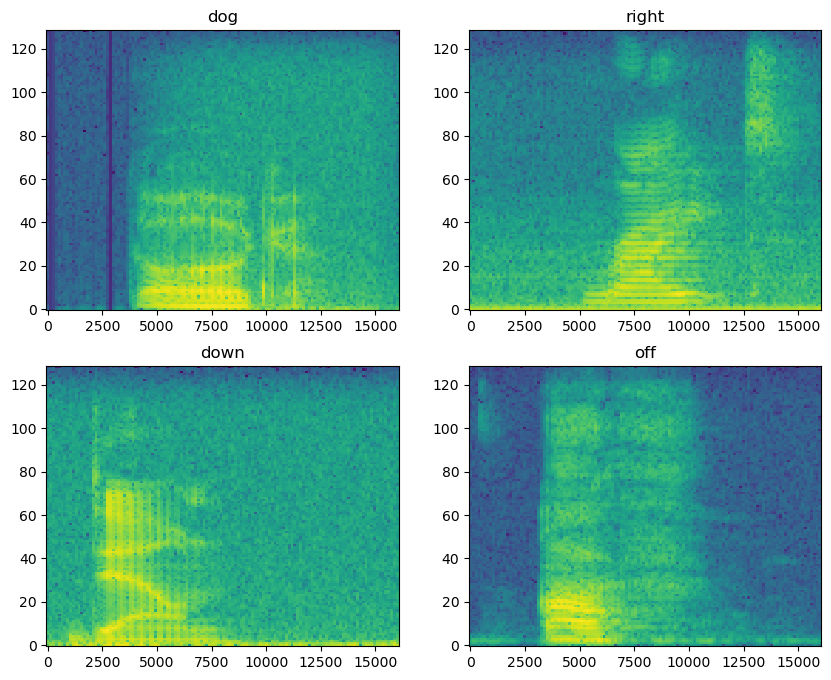

In [16]:
for example_spectrograms, example_spect_labels in trn_spectrogram_ds.take(1):
  break
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [17]:
trn_spectrogram_ds = trn_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
tst_spectrogram_ds = tst_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [18]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)


Input shape: (124, 129, 1)


In [19]:
# CNN Model

from tensorflow.keras import regularizers
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=trn_spectrogram_ds.map(map_func=lambda spec, label: spec))

CNN_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    # layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [20]:
CNN_model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
EPOCHS = 100
CNN_history = CNN_model.fit(
    trn_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/100
154/810 [====>.........................] - ETA: 11s - loss: 3.0409 - accuracy: 0.1521

KeyboardInterrupt: 

In [ ]:
metrics = CNN_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(CNN_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(CNN_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
CNN_model.evaluate(tst_spectrogram_ds, return_dict=True)

In [ ]:
CNN_y_pred = CNN_model.predict(tst_spectrogram_ds)
CNN_y_pred = tf.argmax(CNN_y_pred, axis=1)
CNN_y_true = tf.concat(list(tst_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
CNN_conf_mtx = tf.math.confusion_matrix(CNN_y_true, CNN_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(CNN_conf_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
CNN_precision = precision_score(CNN_y_true, CNN_y_pred, average='macro')
CNN_recall = recall_score(CNN_y_true, CNN_y_pred, average='macro')
CNN_f1 = f1_score(CNN_y_true, CNN_y_pred, average='macro')
print(f'Precision:{CNN_precision}')
print(f'Recall:{CNN_recall}')
print(f'F-1 score:{CNN_f1}')



In [ ]:
# LSTM
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer.adapt(data=trn_spectrogram_ds.map(map_func=lambda spec, label: spec))

LSTM_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.TimeDistributed(layers.Flatten()),  # Apply Flatten to each time step.
    layers.LSTM(64, return_sequences=True),    # LSTM layer with 64 units and return_sequences=True.
    layers.GlobalAveragePooling1D(),          # Reduce time steps to a fixed-size representation.
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

LSTM_model.summary()

In [ ]:
LSTM_model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 50
LSTM_history = LSTM_model.fit(
    trn_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS
)

In [ ]:
LSTM_metrics = LSTM_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(LSTM_history.epoch, LSTM_metrics['loss'], LSTM_metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(LSTM_history.epoch, 100*np.array(LSTM_metrics['accuracy']), 100*np.array(LSTM_metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
LSTM_model.evaluate(tst_spectrogram_ds, return_dict=True)

In [ ]:
LSTM_y_pred = LSTM_model.predict(tst_spectrogram_ds)
LSTM_y_pred = tf.argmax(LSTM_y_pred, axis=1)
LSTM_y_true = tf.concat(list(tst_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
LSTM_conf_mtx = tf.math.confusion_matrix(LSTM_y_true, LSTM_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(LSTM_conf_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
LSTM_precision = precision_score(LSTM_y_true, LSTM_y_pred, average='macro')
LSTM_recall = recall_score(LSTM_y_true, LSTM_y_pred, average='macro')
LSTM_f1 = f1_score(LSTM_y_true, LSTM_y_pred, average='macro')
print(f'Precision:{LSTM_precision}')
print(f'Recall:{LSTM_recall}')
print(f'F-1 score:{LSTM_f1}')

In [ ]:
# Performing Hyperparameter tuning

import keras_tuner
from tensorflow import keras
from keras_tuner import RandomSearch
from tensorflow.keras import layers
from kerastuner.engine.hyperparameters import HyperParameters

norm_layer = layers.Normalization()
def CNN_build_model(hp):
    CNN_hype_model=keras.models.Sequential()
    CNN_hype_model.add(layers.Input(shape=input_shape),)
    # Downsample the input.
    CNN_hype_model.add(layers.Resizing(32, 32),)
    # Normalize.
    CNN_hype_model.add(norm_layer)
    CNN_hype_model.add(layers.Conv2D(hp.Int('conv1_units',min_value=32,max_value=256,step=32),(3,3)))
    CNN_hype_model.add((layers.Activation('relu')))
    CNN_hype_model.add(layers.MaxPooling2D())
    CNN_hype_model.add(layers.Conv2D(hp.Int('conv2_units',min_value=64,max_value=256,step=32), (3, 3)))
    CNN_hype_model.add(layers.Activation('relu'))
    if hp.Boolean('dropout'):
        CNN_hype_model.add(layers.Dropout(0.5))
    CNN_hype_model.add(layers.Flatten()) 
    CNN_hype_model.add(layers.Dense(128, activation='relu'),)
    CNN_hype_model.add(layers.Dense(num_labels))

    CNN_hype_model.compile(optimizer="nadam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return CNN_hype_model
    


In [ ]:
from keras_tuner import RandomSearch
CNN_tuner = RandomSearch(
    CNN_build_model,
    objective='val_accuracy',
    max_trials=50,  # Number of search iteration
    executions_per_trial=1,
    directory=r'C:\Users\udayr\miniconda3\envs\tf\FinalProject'
)

In [ ]:
CNN_tuner.search_space_summary()

In [ ]:
CNN_tuner.get_best_hyperparameters()[0].values

In [ ]:
CNN_tuner.get_best_models()[0].evaluate(tst_spectrogram_ds,return_dict=True)

In [ ]:
#Hyperparameter tuning for LSTM+CNN

def LSTM_build_model(hp):
    LSTM_hype_model=keras.models.Sequential()
    LSTM_hype_model.add(layers.Input(shape=input_shape),)
    # Downsample the input.
    LSTM_hype_model.add(layers.Resizing(32, 32),)
    # Normalize.
    LSTM_hype_model.add(norm_layer)
    
    LSTM_hype_model.add(layers.Conv2D(hp.Int('conv1_units',min_value=32,max_value=256,step=32),(3,3)))
    LSTM_hype_model.add((layers.Activation('relu')))

    LSTM_hype_model.add(layers.Conv2D(hp.Int('conv2_units',min_value=32,max_value=256,step=32),(3,3)))
    LSTM_hype_model.add((layers.Activation('relu')))
    
    LSTM_hype_model.add(layers.MaxPooling2D())

    if hp.Boolean('use_dropout'):
        LSTM_hype_model.add(layers.Dropout(0.25))

    LSTM_hype_model.add(layers.TimeDistributed(layers.Flatten()))

    LSTM_hype_model.add(layers.LSTM(64, return_sequences=True))
    LSTM_hype_model.add(layers.GlobalAveragePooling1D()) 

    if hp.Boolean('use_dropout'):
        LSTM_hype_model.add(layers.Dropout(0.5))
    
    LSTM_hype_model.add(layers.Dense(num_labels))

    LSTM_hype_model.compile(optimizer="nadam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return LSTM_hype_model

In [ ]:
from keras_tuner import RandomSearch
LSTM_tuner =LSTM_ RandomSearch(
    LSTM_build_model,
    objective='val_accuracy',
    max_trials=50,  # Number of search iteration
    executions_per_trial=1,
    directory=r'C:\Users\udayr\miniconda3\envs\tf\FinalProject'
)

In [ ]:
LSTM_tuner.search_space_summary()

In [ ]:
LSTM_tuner.get_best_hyperparameters()[0].values

In [ ]:
LSTM_tuner.get_best_models()[0].evaluate(tst_spectrogram_ds,return_dict=True)